In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.cloud import storage
from astropy.io import fits
from sunpy.map import Map
from astropy import units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map import header_helper

from source.ml_export import crop


In [2]:
def scale_rotate(amap, ratio):
    """

    Parameters
    ----------
    amap

    Returns
    -------

    """

    # TODO This was only calculate for HMI
    # This is the mean sun radius that we want to scale all images to
    mean = 956 * u.arcsec

    rsun_obs = amap.rsun_obs
    print(amap.observer_coordinate)

    scalex = amap.meta['cdelt1']
    scaley = amap.meta['cdelt2']
    
    
    # Calculate specific scaling factor
    #ratio = mean / rsun_obs

    # Rotate solar north up rescale and recenter
    rot_map = amap.rotate(scale=ratio, recenter=True)

    # Update rsun
    rot_map.meta['rsun_obs'] = amap.rsun_obs.value * ratio
    rot_map.meta['rsun_obs_scaled'] = amap.rsun_obs
    #rot_map.meta['cdelt1'] = scalex
    #rot_map.meta['cdelt2'] = scaley
    #rot_map.meta['dsun_obs'] = rot_map.meta['dsun_obs']/ratio.value
    
    
    #logger.info(f'before {rsun_obs} after {rot_map.rsun_obs}')

    # Want image the same size as original so use dimension from input map
    x_scale = ((rot_map.scale.axis1 * amap.dimensions.x) / 2)
    y_scale = ((rot_map.scale.axis2 * amap.dimensions.y) / 2)

    #logger.info(f'x-scale {x_scale}, y-scale {y_scale}')

    #if x_scale != y_scale:
        #logger.error(f'x-scale: {x_scale} and y-scale {y_scale} do not match')

    # Define coordinates
    bottom_left = SkyCoord(-x_scale, -y_scale, frame=rot_map.coordinate_frame)
    top_right = SkyCoord(x_scale, y_scale, frame=rot_map.coordinate_frame)
    print(bottom_left)

    crop_map = rot_map.submap(bottom_left, top_right)

    #logger.info(crop_map.dimensions)

    return crop_map

In [3]:
def scale_rotate2(amap, ratio):
    """

    Parameters
    ----------
    amap

    Returns
    -------

    """

    # TODO This was only calculate for HMI
    # This is the mean sun radius that we want to scale all images to
    mean = 956 * u.arcsec

    rsun_obs = amap.rsun_obs

    scalex = amap.meta['cdelt1']
    scaley = amap.meta['cdelt2']
    
    
    # Calculate specific scaling factor
    ratio = amap.meta['DSUN_REF'] / amap.meta['DSUN_OBS']

    # Rotate solar north up rescale and recenter
    rot_map = amap.rotate(scale=ratio, recenter=True)

    # Update rsun
    rot_map.meta['rsun_obs'] = amap.rsun_obs.value * ratio
    rot_map.meta['rsun_obs_scaled'] = amap.rsun_obs
    rot_map.meta['cdelt1'] = scalex
    rot_map.meta['cdelt2'] = scaley
    rot_map.meta['dsun_obs'] = rot_map.meta['dsun_ref']
    
    
    new_map = Map(rot_map.data, rot_map.header)
    
    #logger.info(f'before {rsun_obs} after {rot_map.rsun_obs}')

    # Want image the same size as original so use dimension from input map
    x_scale = ((new_map.scale.axis1 * amap.dimensions.x) / 2)
    y_scale = ((new_map.scale.axis2 * amap.dimensions.y) / 2)

    #logger.info(f'x-scale {x_scale}, y-scale {y_scale}')

    #if x_scale != y_scale:
        #logger.error(f'x-scale: {x_scale} and y-scale {y_scale} do not match')

    # Define coordinates
    bottom_left = SkyCoord(-x_scale, -y_scale, frame=new_map.coordinate_frame)
    top_right = SkyCoord(x_scale, y_scale, frame=new_map.coordinate_frame)

    crop_map = new_map.submap(bottom_left, top_right)

    return crop_map

In [5]:
def scale_rotate3(amap, ratio):
    """

    Parameters
    ----------
    amap

    Returns
    -------

    """

    # TODO This was only calculate for HMI
    # This is the mean sun radius that we want to scale all images to
    scalex = amap.meta['cdelt1']
    scaley = amap.meta['cdelt2']
    
    ratio = amap.meta['DSUN_REF'] / amap.meta['DSUN_OBS']
    
    # Calculate specific scaling factor
    #ratio = mean / rsun_obs

    # Rotate solar north up rescale and recenter
    rot_map = amap.rotate(scale=ratio, recenter=True)

    # Update rsun
    rot_map.meta['DSUN_OBS'] = rot_map.meta['DSUN_REF']
    coord = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=rotmap.coordinate_frame)
    new_header = header_helper.make_fitswcs_header(rot_map.data, coord, scale=u.Quantity([scalex, scaley]) *u.arcsec/u.pixel)
    new_map = Map(rot_map.data, new_header)
    
    #logger.info(f'before {rsun_obs} after {rot_map.rsun_obs}')

    # Want image the same size as original so use dimension from input map
    x_scale = ((new_map.scale.axis1 * amap.dimensions.x) / 2)
    y_scale = ((new_map.scale.axis2 * amap.dimensions.y) / 2)

    #logger.info(f'x-scale {x_scale}, y-scale {y_scale}')

    #if x_scale != y_scale:
        #logger.error(f'x-scale: {x_scale} and y-scale {y_scale} do not match')

    # Define coordinates
    bottom_left = SkyCoord(-x_scale, -y_scale, frame=new_map.coordinate_frame)
    top_right = SkyCoord(x_scale, y_scale, frame=new_map.coordinate_frame)

    crop_map = new_map.submap(bottom_left, top_right)

    #logger.info(crop_map.dimensions)

    return crop_map

In [6]:
client = storage.Client()

In [7]:
bucket = client.get_bucket('fdl-mag-sdo')
blob = storage.Blob('2012/06/01/hmi.M_720s.20120601_013600_TAI.1.magnetogram.fits',
                        bucket)
blob.download_to_filename('tmp.fits')

In [ ]:
HMI_fits = fits.open('tmp.fits', cache=False)
HMI_fits.verify('fix')
dataHMI = HMI_fits[1].data

# Assemble Sunpy map
HMImap = Map(HMI_fits[1].data, HMI_fits[1].header)
HMImap = HMImap.rotate(scale=1)
HMImap_rot = scale_rotate(HMImap, 956 / HMImap.rsun_obs.value)
HMImap_rot2 = scale_rotate2(HMImap, 956 / HMImap.rsun_obs.value)

In [ ]:
HMImap.rsun_obs

In [8]:
HMImap_crop = crop(HMImap, 100, 100)
HMImap_rotcrop = crop(HMImap_rot, 100, 100)
HMImap_rotcrop2 = crop(HMImap_rot2, 100, 100)

In [9]:
bl = SkyCoord(-400*u.arcsec, -300*u.arcsec, frame=HMImap.coordinate_frame)
tr = SkyCoord(-300*u.arcsec, -200*u.arcsec, frame=HMImap.coordinate_frame)
HMI_crop = HMImap.submap(bl, tr)
bl = SkyCoord(-400*u.arcsec, -300*u.arcsec, frame=HMImap_rot.coordinate_frame)
tr = SkyCoord(-300*u.arcsec, -200*u.arcsec, frame=HMImap_rot.coordinate_frame)
HMI_rotcrop = HMImap_rot.submap(bl, tr)
bl = SkyCoord(-400*u.arcsec, -300*u.arcsec, frame=HMImap_rot2.coordinate_frame)
tr = SkyCoord(-300*u.arcsec, -200*u.arcsec, frame=HMImap_rot2.coordinate_frame)
HMI_rotcrop2 = HMImap_rot2.submap(bl, tr)

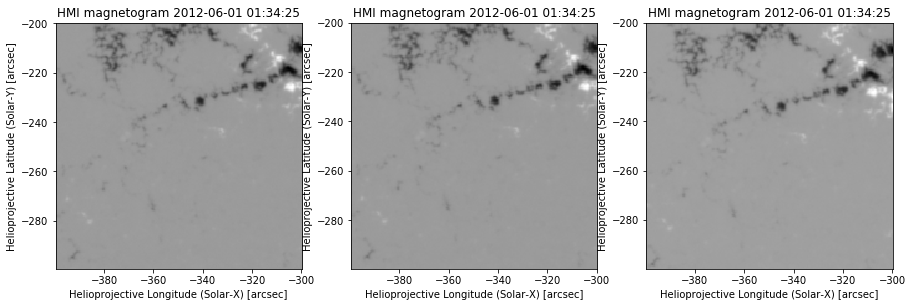

In [10]:
f, a = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
HMI_crop.plot( axes=a[0])
HMI_rotcrop.plot(axes=a[1])
HMI_rotcrop2.plot(axes=a[2])

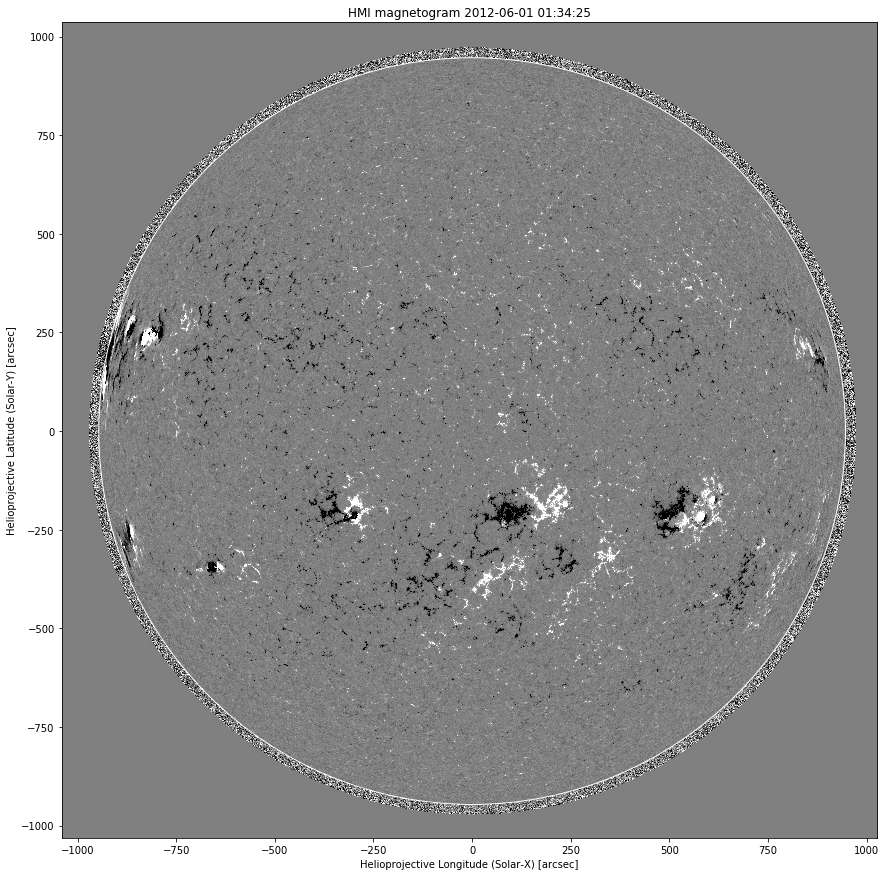

In [11]:
f, a = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
HMImap.plot(axes=a, vmin=-100, vmax=100)
HMImap.draw_limb()

In [15]:
HMImap_rot.meta['rsun_obs'] = HMImap_rot.meta['rsun_obs']  / 1.2

In [16]:
f, a = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
HMImap_rot.plot(axes=a, vmin=-100, vmax=100)
HMImap_rot.draw_limb()
#HMImap_rot2.plot(axes=a[1], vmin=-100, vmax=100)
#HMImap_rot2.draw_limb()

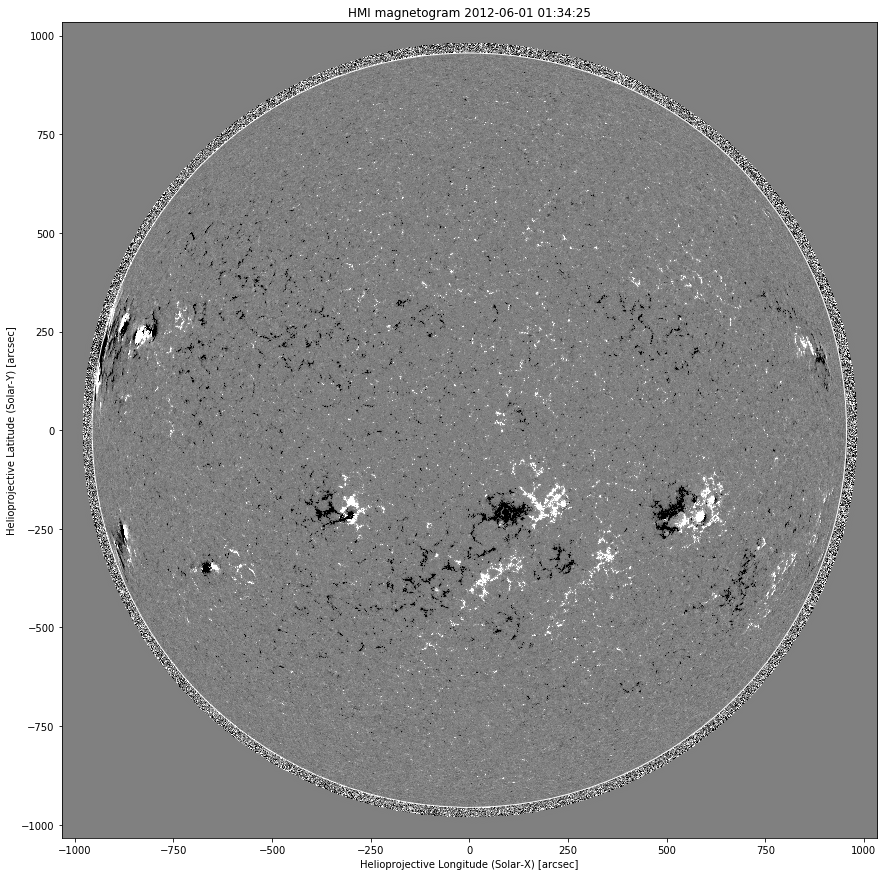

In [20]:
f, a = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
HMImap_rot2.plot(axes=a, vmin=-100, vmax=100)
HMImap_rot2.draw_limb()

In [55]:
# compute difference in mean of magnetic field
HMI_crop.data.mean() - HMI_rotcrop.data.mean()
HMI_crop.data.mean() - HMI_rotcrop2.data.mean()

1.5637548836920097

In [116]:
# create a hand crafted map to test scale_rotate and scale_rotate2
data = np.diag(np.arange(-1000, 1000))
print(data.shape)
coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime='2019-07-23 10:00', observer='earth', frame=frames.Helioprojective)
header = header_helper.make_fitswcs_header(data, coord, 
                                                     reference_pixel=u.Quantity([1000.5, 1000.5]*u.pixel),
                                                     scale=u.Quantity([0.5, 0.5]*u.arcsec/u.pixel),
                                                     telescope='Fake Telescope', instrument='UV detector',
                                                     )
test_map = Map(data, header)

(2000, 2000)


In [128]:
test_map1 = test_map.rotate(scale=1.0)
test_map2 = scale_rotate(test_map, 0.5)
test_map3 = scale_rotate2(test_map, 0.5)

<SkyCoord (Helioprojective: obstime=2019-07-23T10:00:00.000, rsun=695700000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2019-07-23T10:00:00.000): (lon, lat, radius) in (deg, deg, m)
    (0., 5.05611189, 1.51986867e+11)>): (Tx, Ty) in arcsec
    (-1000., -1000.)>


(-500, 500)

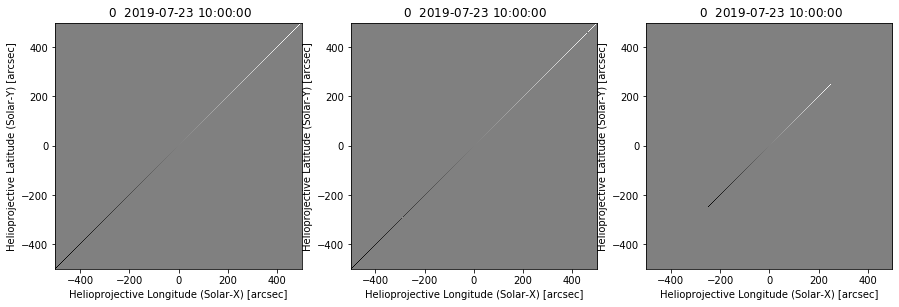

In [134]:
f, a = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
test_map1.plot( axes=a[0])
a[0].set_xlim(-500, 500)
a[0].set_ylim(-500, 500)
test_map2.plot(axes=a[1])
a[1].set_xlim(-500, 500)
a[1].set_ylim(-500, 500)
test_map3.plot(axes=a[2])
a[2].set_xlim(-500, 500)
a[2].set_ylim(-500, 500)

In [135]:
bl = SkyCoord(-50*u.arcsec, -50*u.arcsec, frame=test_map1.coordinate_frame)
tr = SkyCoord(50*u.arcsec, 50*u.arcsec, frame=test_map1.coordinate_frame)
t_crop1 = test_map1.submap(bl, tr)
bl = SkyCoord(-50*u.arcsec, -50*u.arcsec, frame=test_map2.coordinate_frame)
tr = SkyCoord(50*u.arcsec, 50*u.arcsec, frame=test_map2.coordinate_frame)
t_crop2 = test_map2.submap(bl, tr)
bl = SkyCoord(-50*u.arcsec, -50*u.arcsec, frame=test_map3.coordinate_frame)
tr = SkyCoord(50*u.arcsec, 50*u.arcsec, frame=test_map3.coordinate_frame)
t_crop3 = test_map3.submap(bl, tr)

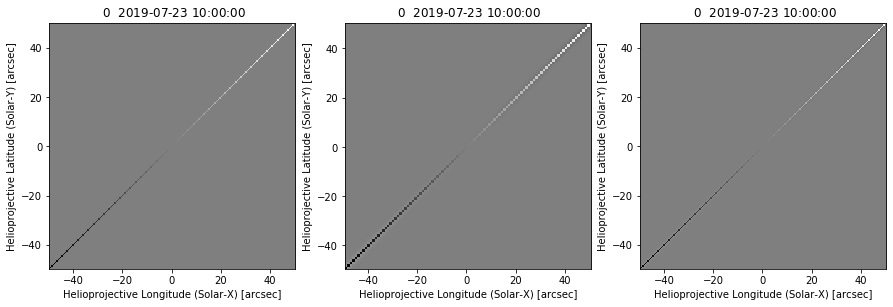

In [136]:
f, a = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
t_crop1.plot( axes=a[0])
t_crop2.plot(axes=a[1])
t_crop3.plot(axes=a[2])

In [143]:
data_crop2 = t_crop2.data
print(np.diagonal(data_crop2).shape)
data_crop3 = t_crop3.data
print(np.diagonal(data_crop3).shape)

(100,)
(200,)


In [145]:
print(data_crop2.shape)
print(data_crop3.shape)

(100, 100)
(200, 200)
